<a href="https://colab.research.google.com/github/joaoangnes/us-accident-analysis/blob/main/us_accident_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup do Dataset

In [1]:
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joaoangnes","key":"b8c9a90d94797aa1a9727c6f067bbc2c"}'}

In [3]:
%pip install kaggle -q
%pip install pyarrow
%pip install missingno
%pip install seaborn
%pip install plotly
%pip install dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4



# US-Accident Exploratory Data Analysis
## About Dataset

Description This is a countrywide car accident dataset that covers 49 states of the USA. The accident data were collected from February 2016 to March 2023, using multiple APIs that provide streaming traffic incident (or event) data. These APIs broadcast traffic data captured by various entities, including the US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors within the road networks. The dataset currently contains approximately 7.7 million accident records. For more information about this dataset, please visit here.

Acknowledgements If you use this dataset, please kindly cite the following papers:

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.

Content This dataset was collected in real-time using multiple Traffic APIs. It contains accident data collected from February 2016 to March 2023 for the Contiguous United States. For more details about this dataset, please visit [here].

Inspiration The US-Accidents dataset can be used for numerous applications, such as real-time car accident prediction, studying car accident hotspot locations, casualty analysis, extracting cause and effect rules to predict car accidents, and studying the impact of precipitation or other environmental stimuli on accident occurrence. The most recent release of the dataset can also be useful for studying the impact of COVID-19 on traffic behavior and accidents.

Sampled Data (New!) For those requiring a smaller, more manageable dataset, a sampled version is available which includes 500,000 accidents. This sample is extracted from the original dataset for easier handling and analysis.

Other Details Please note that the dataset may be missing data for certain days, which could be due to network connectivity issues during data collection. Regrettably, the dataset will no longer be updated, and this version should be considered the latest.

Usage Policy and Legal Disclaimer This dataset is being distributed solely for research purposes under the Creative Commons Attribution-Noncommercial-ShareAlike license (CC BY-NC-SA 4.0). By downloading the dataset, you agree to use it only for non-commercial, research, or academic applications. If you use this dataset, it is necessary to cite the papers mentioned above.

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
%cd /content/
!kaggle datasets download sobhanmoosavi/us-accidents

/content
Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
 97% 632M/653M [00:02<00:00, 275MB/s]
100% 653M/653M [00:02<00:00, 254MB/s]


In [6]:
!unzip us-accidents.zip -d us-accidents

Archive:  us-accidents.zip
  inflating: us-accidents/US_Accidents_March23.csv  


In [95]:
import pandas as pd
import dask.dataframe as dd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sb

### Bonus:
Realizado um benchmarking de utilizar pandas ou dask em arquivos .csv grandes

### Importação do Dataset com Pandas
Realizado com dividindo o processamento em chunks

In [44]:
# Definir o tamanho de cada chunk
chunk_size = 100000

# Criar uma lista para armazenar os chunks
chunks = []

# Iterar sobre o dataset em pedaços
for chunk in pd.read_csv('/content/us-accidents/US_Accidents_March23.csv', chunksize=chunk_size):
    chunks.append(chunk)

# Concatenar todos os chunks em um único DataFrame
df_pandas = pd.concat(chunks)

# Agora você pode analisar o dataset inteiro
df_pandas.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


## Importação do Dataset com Dask

In [9]:
# Ler o arquivo CSV diretamente em um DataFrame Dask
%time df_dask = dd.read_csv('/content/us-accidents/US_Accidents_March23.csv')

# Agora você pode realizar operações em df_dask
df_dask.head()

CPU times: user 28.7 ms, sys: 1.93 ms, total: 30.7 ms
Wall time: 30.7 ms


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


## Convertendo o dataframe para arquivo parquet com Dask

In [10]:
%time df_dask.to_parquet('/content/us-accidents/US_Accidents_March23.parquet.gzip', compression='gzip', engine='pyarrow')

In [14]:
# Ler o arquivo Parquet
%time df_parquet_dask = dd.read_parquet('/content/us-accidents/US_Accidents_March23.parquet.gzip')

# Exibir as primeiras linhas do DataFrame
df_parquet_dask.head()

CPU times: user 20.8 ms, sys: 1.08 ms, total: 21.9 ms
Wall time: 21.6 ms


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [129]:
# Ler o arquivo Parquet
%time df_parquet_pandas = pd.read_parquet('/content/us-accidents/US_Accidents_March23.parquet.gzip')

# Exibir as primeiras linhas do DataFrame
df_parquet_pandas.head()

CPU times: user 25.7 s, sys: 12.7 s, total: 38.3 s
Wall time: 16 s


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


### Analise do Dataset
### Tarefas:

[1] - Limpeza de Dados: Preparar os dados, eliminando duplicatas e preenchendo valores faltantes.

[2] - Análise Exploratória: Usar seaborn para identificar correlações e padrões entre os acidentes e as variáveis disponíveis.

[3] - Visualizações Interativas: Criar gráficos interativos com plotly, como mapas interativos para mostrar onde os acidentes mais graves ocorrem.

[4] - Análise Temporal: Usar heatmaps de tempo para identificar em quais horários ou dias da semana os acidentes são mais frequentes.

In [45]:
%time df_parquet_pandas.shape

CPU times: user 43 µs, sys: 10 µs, total: 53 µs
Wall time: 75.6 µs


(7728394, 46)

In [21]:
%time df_parquet_dask.shape

CPU times: user 1.62 ms, sys: 0 ns, total: 1.62 ms
Wall time: 1.59 ms


(Delayed('int-043ae353-9963-474d-98a8-acace68d2977'), 46)

In [22]:
%time df_parquet_pandas.columns

CPU times: user 22 µs, sys: 4 µs, total: 26 µs
Wall time: 45.3 µs


Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [23]:
%time df_parquet_dask.columns

CPU times: user 23 µs, sys: 5 µs, total: 28 µs
Wall time: 46.3 µs


Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [30]:
%time df_parquet_pandas.describe()

CPU times: user 4.12 s, sys: 1.21 s, total: 5.33 s
Wall time: 5.3 s


,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


In [29]:
%time df_parquet_dask.describe().compute()

CPU times: user 11.5 s, sys: 4.52 s, total: 16.1 s
Wall time: 4.29 s


,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.403100e+01,-9.785238e+01,3.403112e+01,-1.171213e+02,0.000000e+00,5.700000e+01,5.400000e+01,5.700000e+01,2.969000e+01,1.000000e+01,5.800000e+00,0.000000e+00
50%,2.000000e+00,3.903448e+01,-8.476065e+01,3.903322e+01,-8.501319e+01,1.390000e-01,7.000000e+01,7.000000e+01,7.600000e+01,2.996000e+01,1.000000e+01,8.100000e+00,0.000000e+00
75%,3.000000e+00,4.224331e+01,-8.004351e+01,4.224285e+01,-8.004272e+01,1.078000e+00,8.600000e+01,8.600000e+01,8.900000e+01,3.030000e+01,1.000000e+01,1.200000e+01,5.000000e-02
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


### Análise - [1] Limpeza de Dados
* Analisando dados nulos

In [68]:
missing_data = df_parquet_pandas.isnull().sum()
data_types = df_parquet_pandas.dtypes

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Data Type': data_types
})

missing_data_df.sort_values(ascending = False, by='Missing Values')

,Missing Values,Data Type
End_Lng,3402762,float64
End_Lat,3402762,float64
Precipitation(in),2203586,float64
Wind_Chill(F),1999019,float64
Wind_Speed(mph),571233,float64
Visibility(mi),177098,float64
Wind_Direction,175206,string[python]
Humidity(%),174144,float64
Weather_Condition,173459,string[python]
Temperature(F),163853,float64


## Porcentagem de valores nulos em cada coluna

Existe uma grande concentração de dados faltantes nas colunas:

* End_Lng           = Mostra a latitude em coordenadas GPS do ponto final.
*	End_Lat           = Mostra a longitude em coordenadas GPS do ponto final.
*	Precipitation(in) = Mostra a quantidade de precipitação em polegadas, se houver.
*	Wind_Chill(F)     = Mostra a sensação térmica do vento (em Fahrenheit).
* Wind_Speed(mph) = Velocidade do vento em milhas por hora

Já o restante das variaveis não apresentam um quantidade expressiva de dados faltantes

<Axes: >

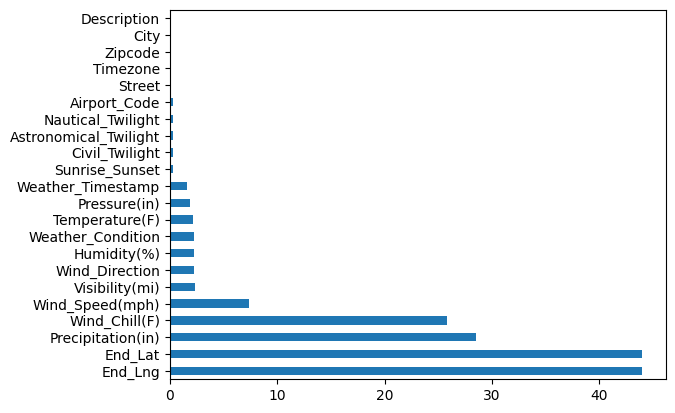

In [57]:
missing_percentage = df_parquet_pandas.isna().sum().sort_values(ascending = False) / len(df_parquet_pandas) * 100
missing_percentage[missing_percentage != 0].plot(kind="barh")

<Axes: >

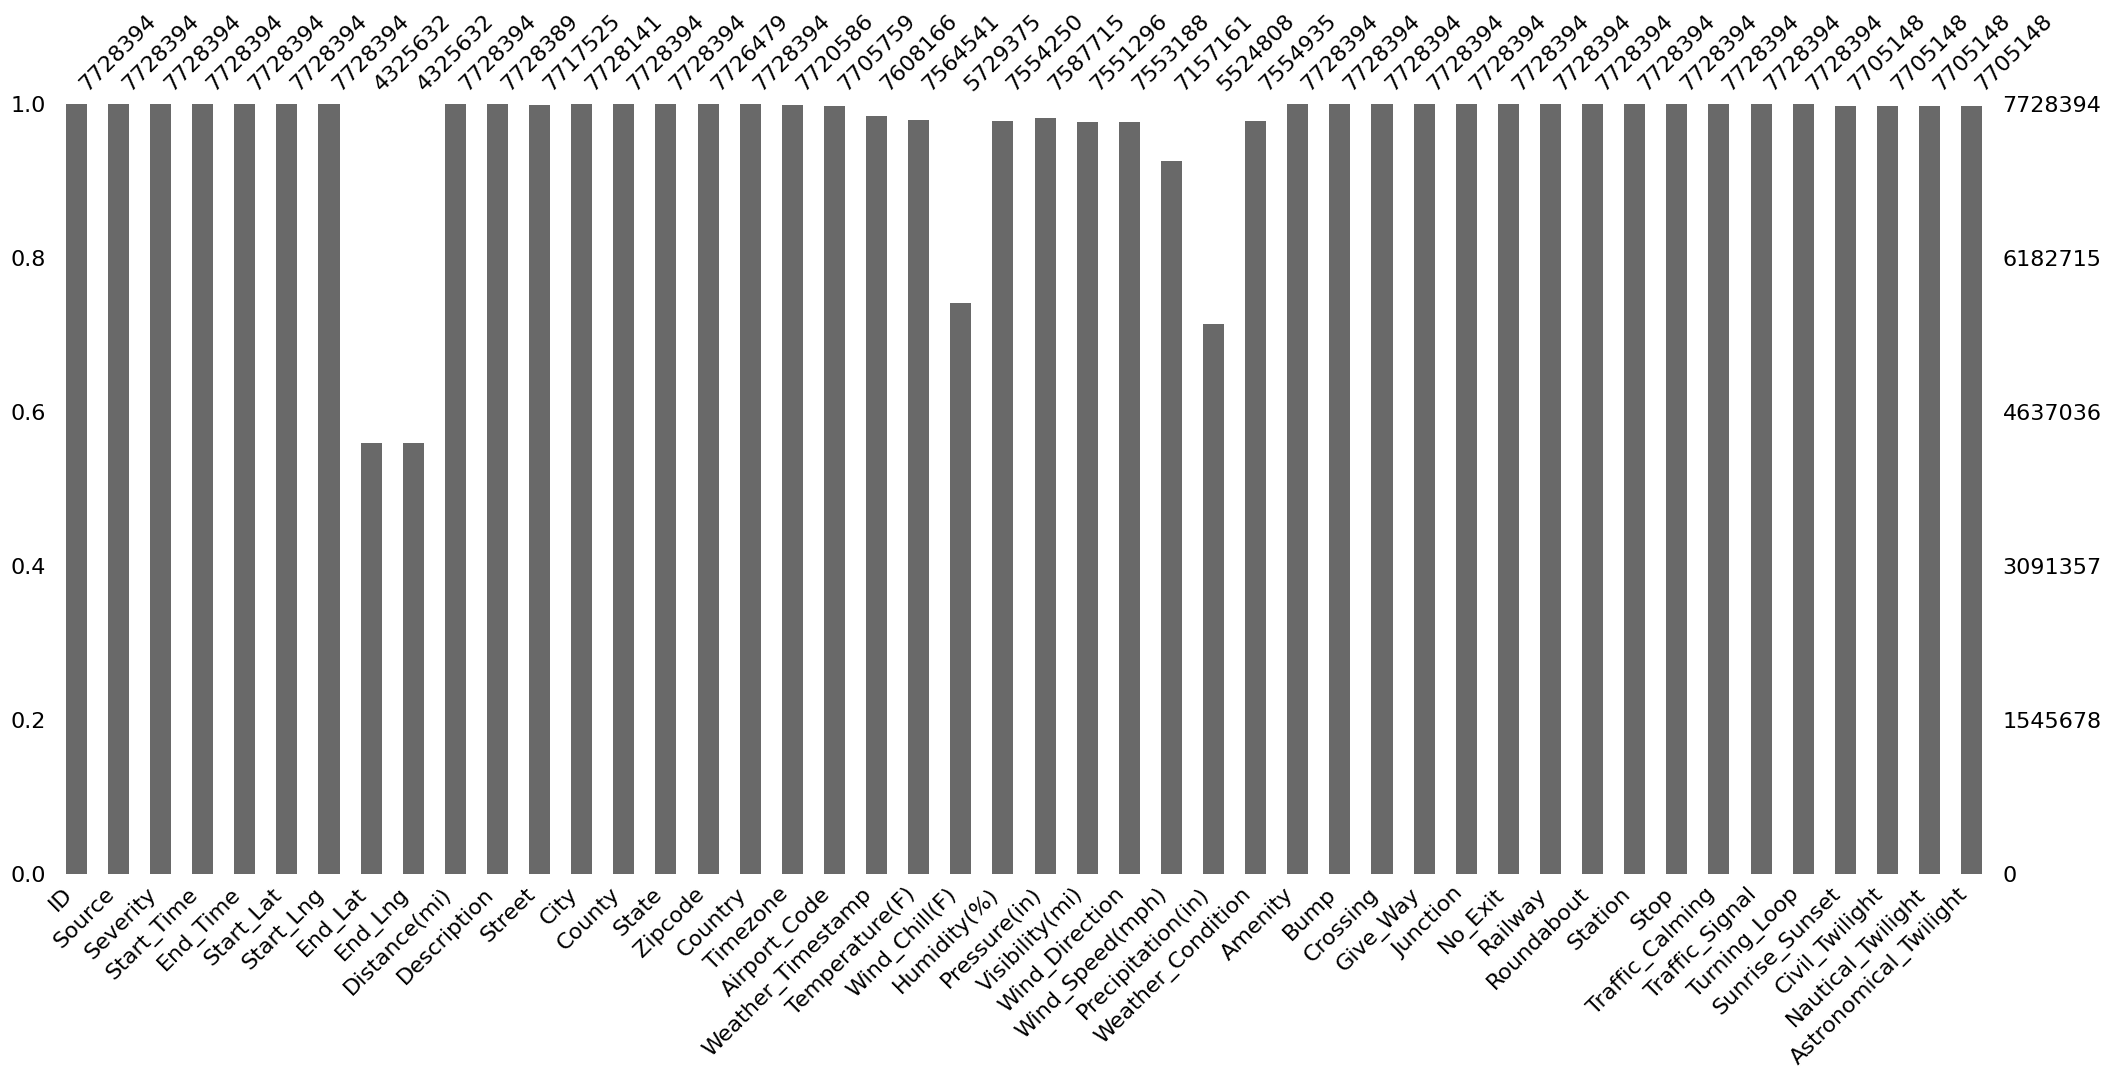

In [59]:
msno.bar(df_parquet_pandas)

In [119]:
# Calcular estatísticas descritivas
def estatisticas_numericas(df, coluna):
    media = df[coluna].mean()
    mediana = df[coluna].median()
    moda = df[coluna].mode()[0]
    desvio_padrao = df[coluna].std()

    print(f"Estatísticas de {coluna}:")
    print(f"Média: {media}")
    print(f"Mediana: {mediana}")
    print(f"Moda: {moda}")
    print(f"Desvio Padrão: {desvio_padrao}")

def comparacao(col):
  x = df_parquet_pandas[col].unique() # Valores unicos
  title = col
  sb.set(style='whitegrid')

  # Aumentando o tamanho da figura e usando gridspec para ajustar a altura dos gráficos
  fig = plt.figure(figsize=(12, 15))
  gs = fig.add_gridspec(3, 1)

  # Histogram
  ax1 = fig.add_subplot(gs[0, 0])
  sb.histplot(x, ax=ax1, kde=True)  # Substituir distplot por histplot
  ax1.set_title('Histogram')

  # BoxPlot
  ax2 = fig.add_subplot(gs[1, 0])
  sb.boxplot(x=x, ax=ax2, color='lightblue')
  ax2.set_title('BoxPlot')

  # ViolinPlot
  ax3 = fig.add_subplot(gs[2, 0])
  sb.violinplot(x=x, ax=ax3, inner='quartile', color='lightgreen')
  ax3.set_title('ViolinPlot')

  # Ajustar o título da figura
  fig.suptitle(title, fontsize=16)

  plt.tight_layout()  # Melhora o layout
  plt.show()
  estatisticas_numericas(df_parquet_pandas, col)

## Analise End_Lng
Distribuição Assimética, com muitos outliers, sem muitas concentrações de dados em um local só

Nesse caso iremos utilizar a mediana para substituir os valores faltantes, para que não seja impactado pelos valores extremos.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


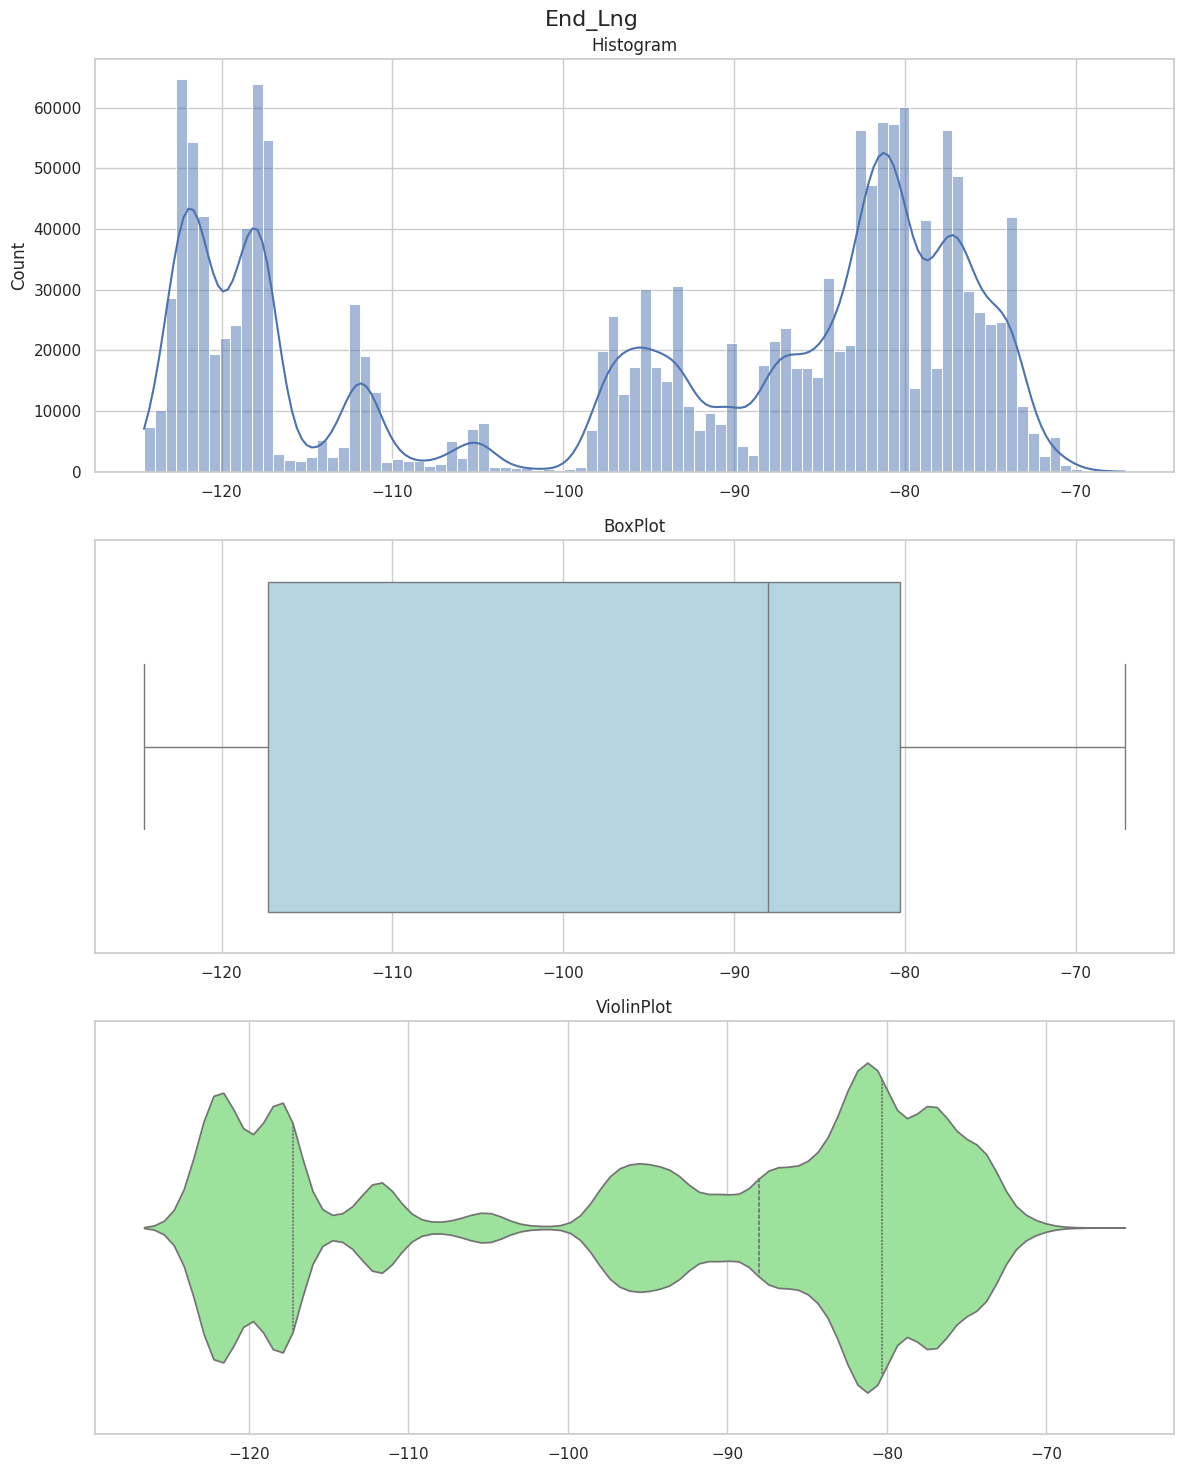

Estatísticas de End_Lng:
Média: -95.72557026006888
Mediana: -88.02789000000001
Moda: -81.471375
Desvio Padrão: 18.10792763629349


In [120]:
col = 'End_Lng'
comparacao(col)

## Analise End_Lat
Distribuição Assimética, com poucos outliers, sem muitas concentrações de dados em um local só.

Nesse caso iremos utilizar a mediana para substituir os valores faltantes, porém nessa amostra, poderiamos utilizar a média que irá obter praticamente o mesmo resultado.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


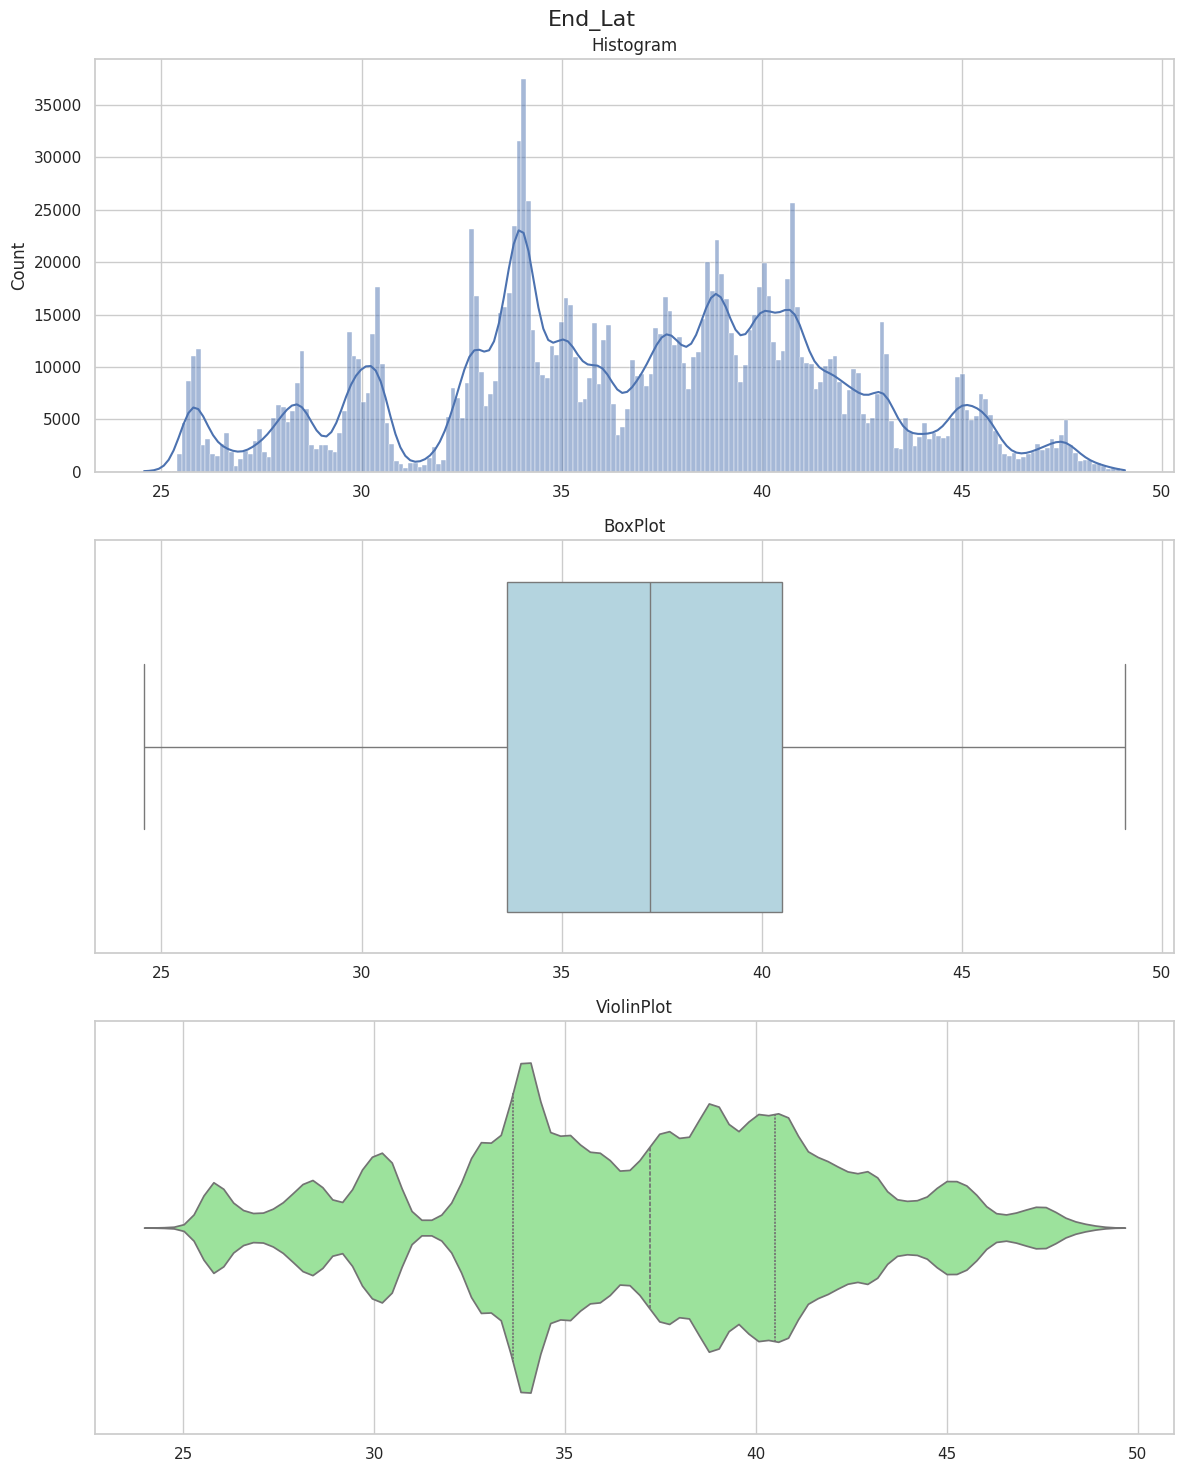

Estatísticas de End_Lat:
Média: 36.26182889162044
Mediana: 36.18349450000001
Moda: 28.450015000000004
Desvio Padrão: 5.2729045393846325


In [122]:
col = 'End_Lat'
comparacao(col)

## Analise Wind_Chill(f)
Distribuição Assimética, com alguns outliers e contém uma grande concentração de dados entre -40 até 40.

Nesse caso iremos utilizar a mediana para substituir os valores faltantes, para que não seja impactado pelos valores extremos.

Poderiamos também utilizar a Moda, já que existe uma grande concentração de dado.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


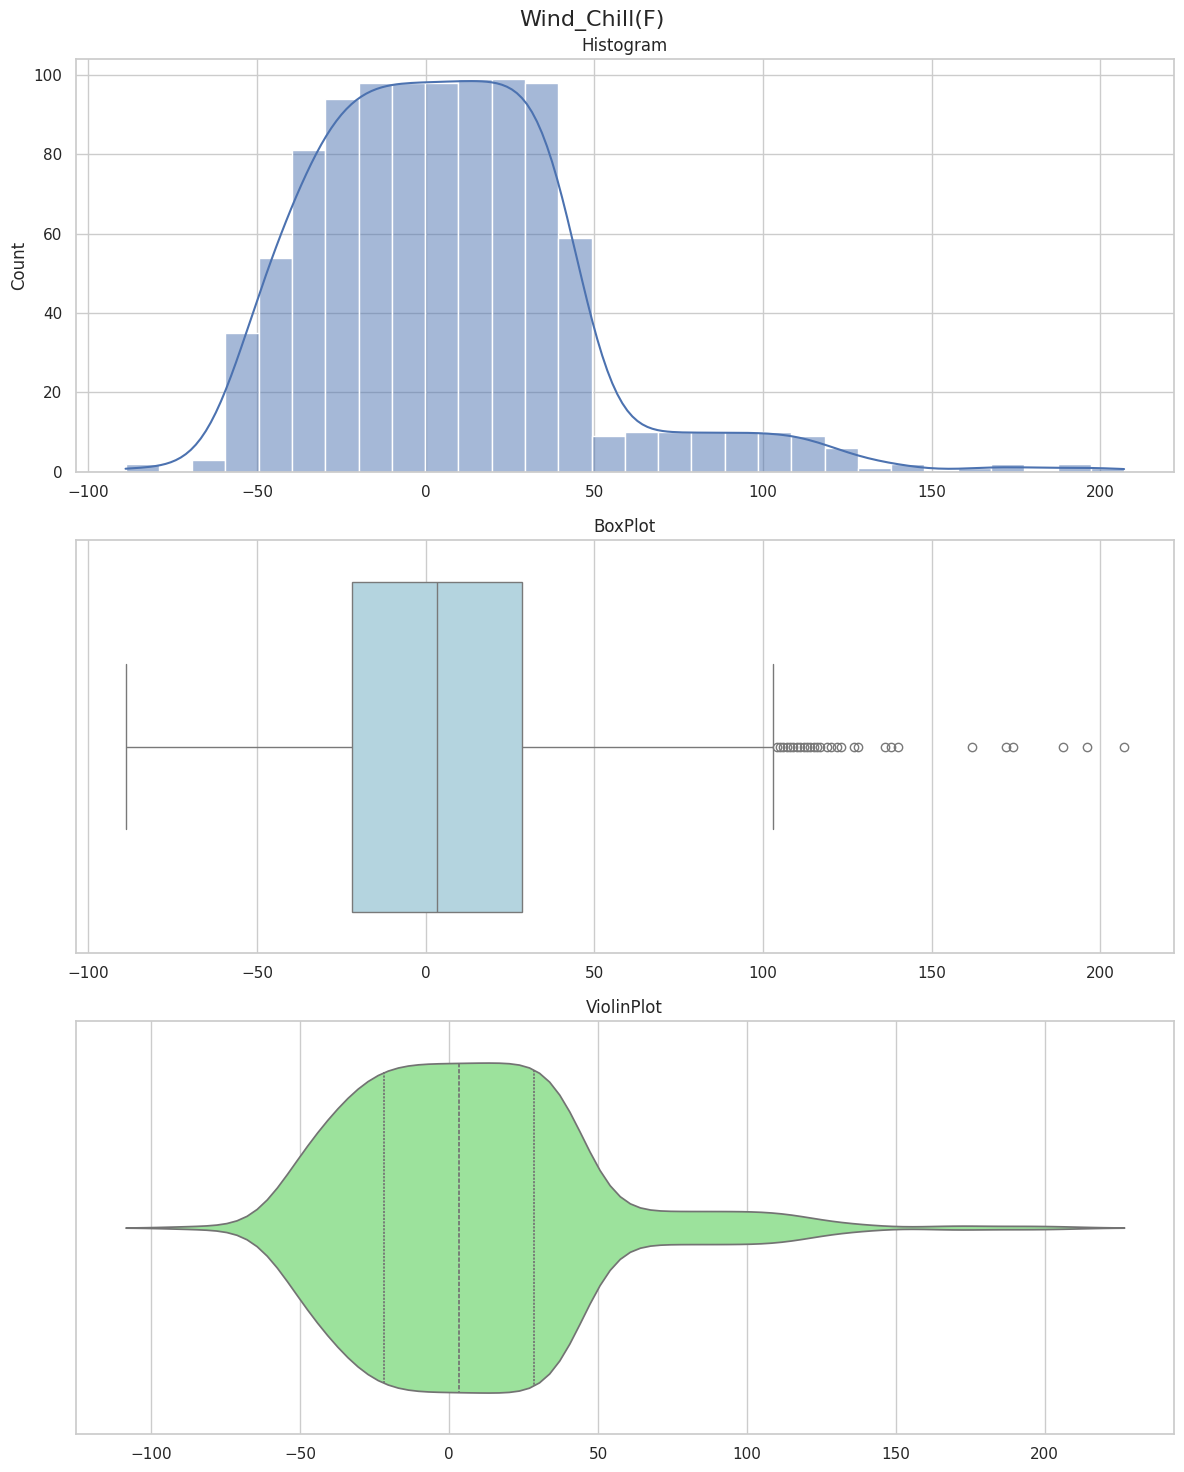

Estatísticas de Wind_Chill(F):
Média: 58.25104839533108
Mediana: 62.0
Moda: 73.0
Desvio Padrão: 22.38983174962068


In [123]:
col = 'Wind_Chill(F)'
comparacao(col)

## Analise Wind_Speed(mph)
Distribuição Assimética com concentração a esquerda, com alguns outlier mostrados na longa cauda a direita no Histograma e ViolinPlot.

Nesse caso iremos utilizar a mediana para substituir os valores faltantes, para que não seja impactado pelos valores extremos.


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


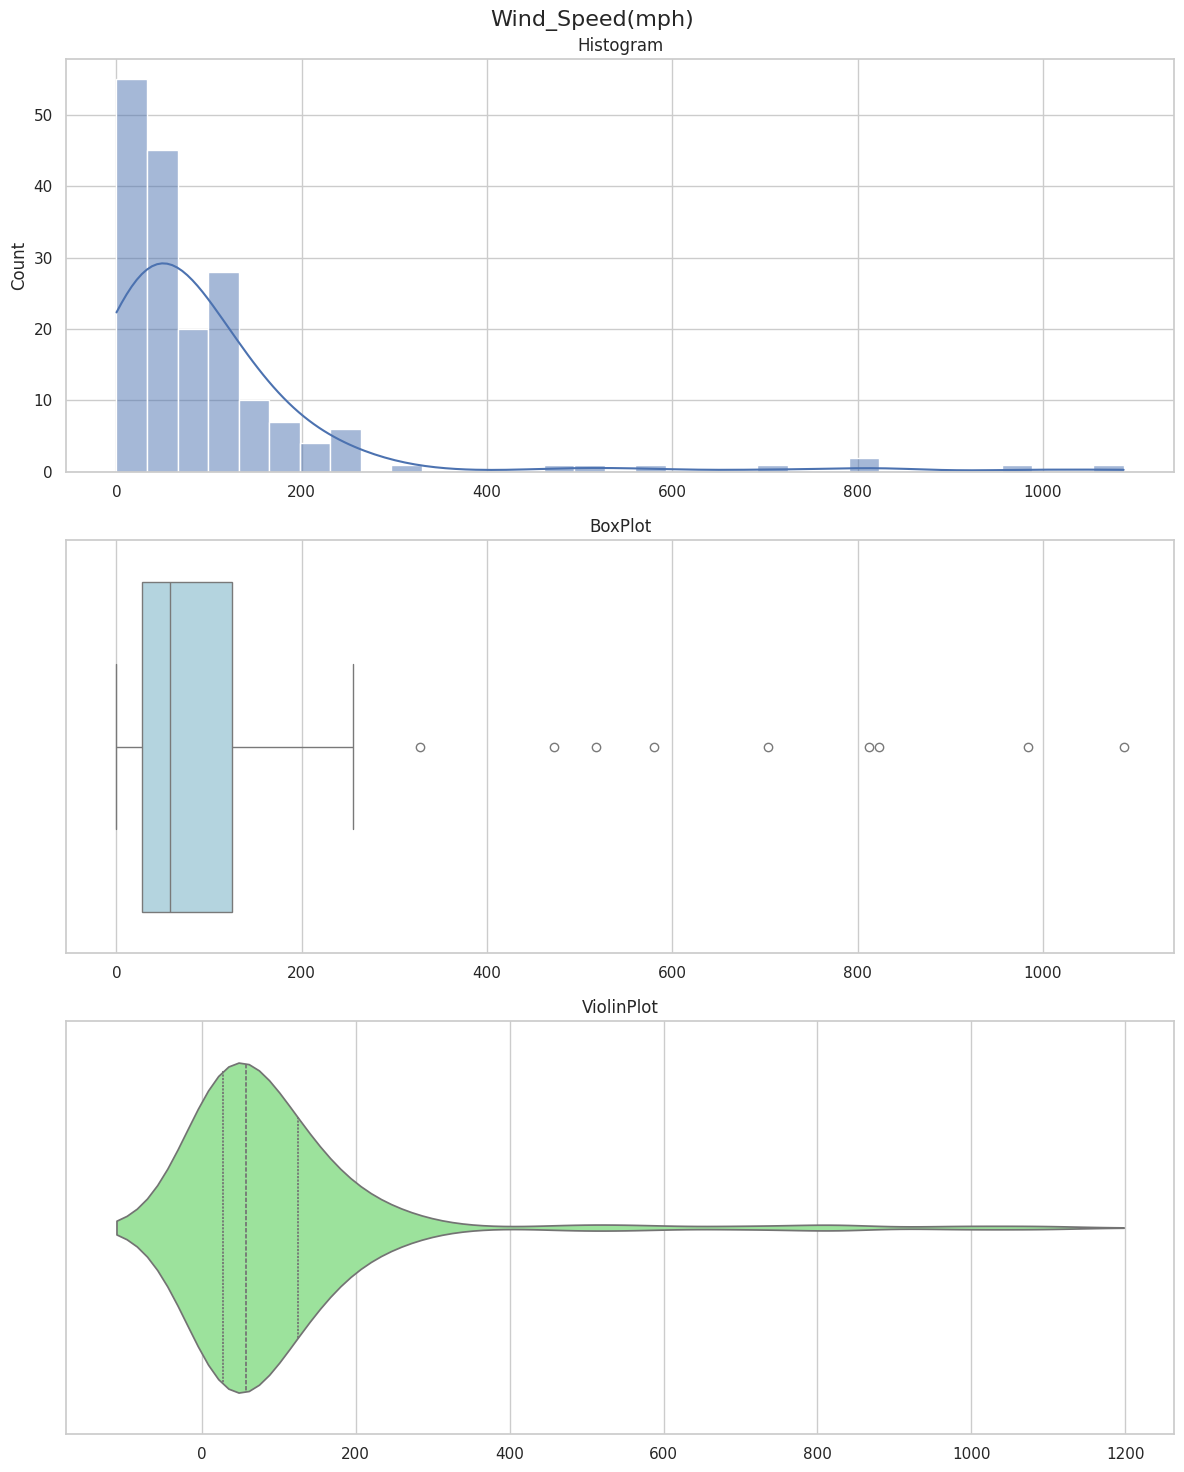

Estatísticas de Wind_Speed(mph):
Média: 7.6854895956651
Mediana: 7.0
Moda: 0.0
Desvio Padrão: 5.424983437161067


In [124]:
col = 'Wind_Speed(mph)'
comparacao(col)

## Tratamento dos dados Nulos

### Varivaveis mais relevantes
### Numéricas:
=> Tratando os dados faltantes com o resultado da mediana da coluna
* End_Lng
* End_Lat &
* Precipitation(in)
* Wind_Chill(F)
* Wind_Speed(mph)

### Variaveis menos relevantes
* Númericos = Tratando os dados faltantes com o resultado da mediana da coluna
* Categoricos = Alterar os dados faltantes para 'Desconhecido'


In [131]:
def tratar_dados(df):
    # Variáveis Relevantes
    # Preencher variáveis relevantes numéricas com a mediana
    df['End_Lng'] = df['End_Lng'].fillna(df['End_Lng'].median())
    df['End_Lat'] = df['End_Lat'].fillna(df['End_Lat'].median())
    df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())
    df['Wind_Chill(F)'] = df['Wind_Chill(F)'].fillna(df['Wind_Chill(F)'].median())
    df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())

    # Variáveis Menos Relevantes - Preencher as variáveis numéricas com a mediana
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())


    # Variáveis Menos Relevantes - Preencher as variáveis categóricas com 'Unknown'
    categorical_columns = df.select_dtypes(include=['object', 'string', 'category']).columns
    for col in categorical_columns:
        df[col] = df[col].fillna('Unknown')

    return df

<Axes: >

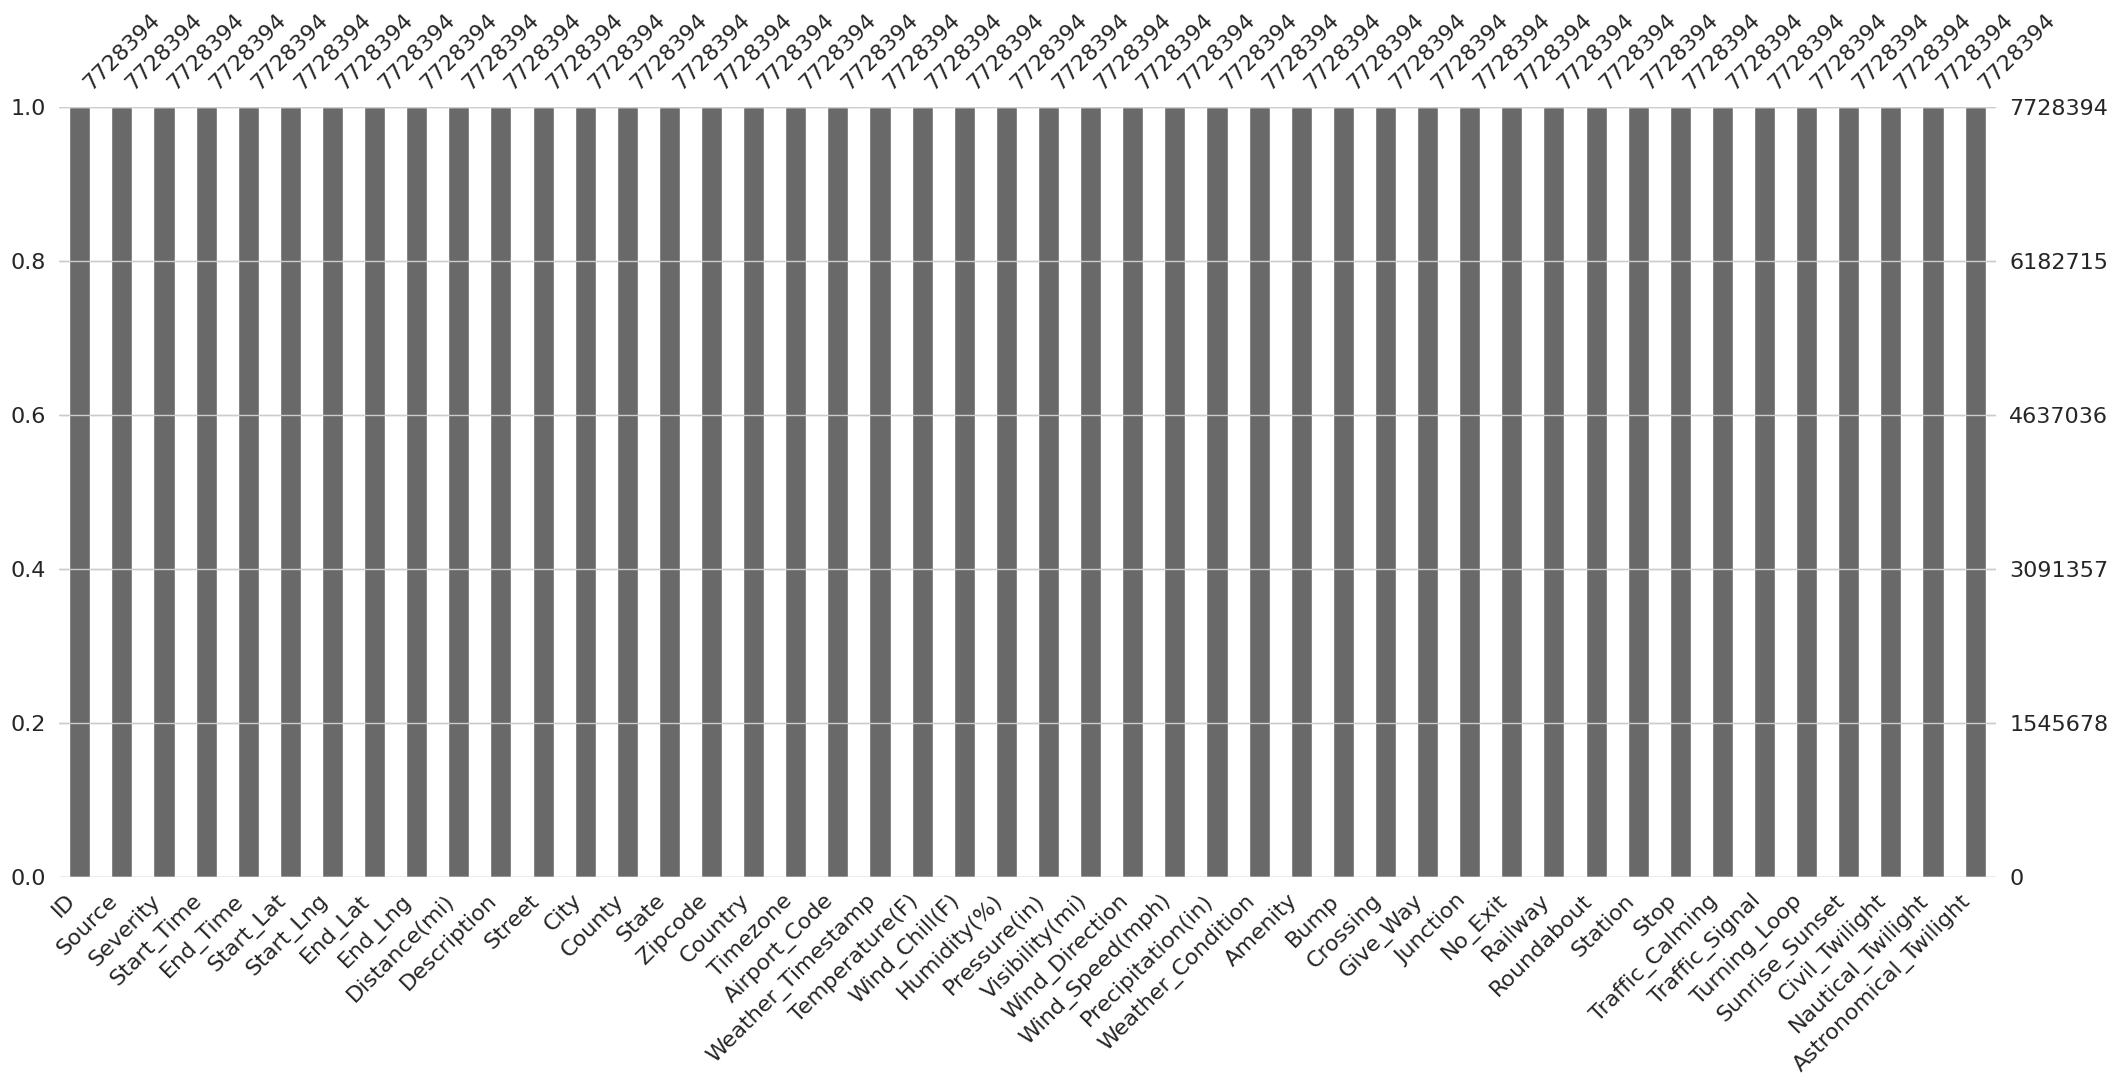

In [132]:
# Aplicar a função ao DataFrame principal
df_parquet_pandas_nan_clean = tratar_dados(df_parquet_pandas)

msno.bar(df_parquet_pandas_nan_clean)